## INGENIAS - Grupo 6. Aprendizaje Supervisado - Modelos de Clasificación - Variable: VIAJES EN TRANSPORTE PÚBLICO

## Carga de datos

In [1]:
#Importamos librerías con las que se van a trabajar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sklearn
import warnings
# Ignorar todos los warnings
warnings.filterwarnings('ignore')
# Ignorar un warning específico por categoría
warnings.filterwarnings('ignore', category=DeprecationWarning)

###  Aprendizaje Supervisado

### 1) Clasificación 

In [2]:
personas=pd.read_csv('../datos/personas_l.csv')

In [3]:
viajes=pd.read_csv('../datos/viajes_l.csv')

In [4]:
# Función auxiliar Feature Importance
def feature_importance(model, feature_list):
    """
    Function that gets and plots the feature importance
    for the given model
    :param model: the model to evaluaate
    :param feature_list: a list of features contained in the model

    :returns a plot with feature importance
    """
    importances = list(model.feature_importances_)
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    [print('Variable: {} Importance: {}'.format(*pair)) for pair in feature_importances];
    colors = plt.cm.rainbow(np.linspace(0, 1, len(feature_list))) 
    characteristics = [x[0] for x in feature_importances]
    importances_plot = [x[1] for x in feature_importances]
    plt.bar(characteristics, importances_plot, color=colors)
    plt.xticks(list(range(len(characteristics))), characteristics, rotation = 90)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gcf().subplots_adjust(bottom=0.3);

###  Procesamiento y transformación de datos 

Transformamos la variable `modo_des` utilizando el Método Apply: asignamos 1 a "Viajes en Transporte Público", y 0 a "Otros motivos".

In [5]:
cat_asignar_1 = [4,7,8]

In [6]:
viajes['modo_des'] = viajes['modo_des'].apply(lambda x: 1 if x in cat_asignar_1 else 0)

In [7]:
viajes.head()

,Unnamed: 0,id_hogar,id_persona,id_viaje,actividad_en_el_origen,actividad_en_el_destino,BH_NBH,motivo,veces_por_semana_viaja,tarifa_combinada,...,hora_final,duracion_minutos,modo_des,PONDERA,cantidad_etapas,tipo_viaje,menos_2_cuadras,Inluye_bici,viaja_rmba,distancia_viaje_km
0,0,1,2,1,1,2,BH,2,5,0,...,10.666667,40.0,0,503,1,PBA,0,no,1,0.011419
1,1,1,2,2,2,1,BH,2,5,0,...,17.666667,40.0,0,503,1,PBA,0,no,1,0.011419
2,2,2,1,1,1,3,BH,3,88,0,...,10.250000,60.0,1,464,1,PBA,0,no,1,0.030933
3,3,2,1,2,3,1,BH,3,88,0,...,13.000000,60.0,1,464,1,PBA,0,no,1,0.030933
4,4,3,1,1,1,7,BH,7,88,0,...,12.000000,180.0,0,462,1,PBA,0,no,1,0.032295


Para las variables `partido_origen_viaje`, `tipo_viaje`y `partido-origen_destino`, utilizaremos `LabelEncoder`, ya que si bien no tienen un orden inherente, optando por `.get_dummies`, nos insumiría demasiado espacio en la memoria.

In [8]:
from sklearn.preprocessing import LabelEncoder

In [9]:
origen_encoder = LabelEncoder()

In [10]:
viajes.loc[:, 'partido_origen_viaje'] = origen_encoder.fit_transform(viajes['partido_origen_viaje'])

In [11]:
destino_encoder = LabelEncoder()

In [12]:
viajes.loc[:, 'partido_destino_viaje'] = destino_encoder.fit_transform(viajes['partido_destino_viaje'])

In [13]:
tpoviaj_encoder = LabelEncoder()

In [14]:
viajes.loc[:, 'tipo_viaje'] = tpoviaj_encoder.fit_transform(viajes['tipo_viaje'])

A continuación se unirán los datasets "Personas" con "Viajes", de manera que el Modelo pueda considerar algunas características de las personas que viajan. Dado que los mismos son muy grandes y no hay espacio suficiente, eliminaremos algunas columnas que no se incluirán en el modelo.

In [15]:
personas.drop(labels=['partido', 'nombre_partido', 'relacion_con_jefe_de_hogar', 'dificultad', 'nivel_cursando', 'cursa_actualmente', 'situacion_laboral', 'por_que_no_trabajo', 'por_que_no_trabajo_otro','por_que_no_tiene_empleo_remunerado','por_que_no_tiene_empleo_otro', 'forma_aporte', 'ambito_laboral','ambito_laboral_otro', 'cobertura', 'lugar_atencion', 'lugar_atencion', 'viajo_ayer','motivos_no_viajo_ayer','PONDERA'], axis=1, inplace=True)


In [16]:
viajes.columns

Index(['Unnamed: 0', 'id_hogar', 'id_persona', 'id_viaje',
       'actividad_en_el_origen', 'actividad_en_el_destino', 'BH_NBH', 'motivo',
       'veces_por_semana_viaja', 'tarifa_combinada', 'jur_origen',
       'jur_destino', 'partido_origen_viaje', 'partido_destino_viaje',
       'cod_partido_origen', 'cod_partido_destino', 'hora_inicio',
       'hora_final', 'duracion_minutos', 'modo_des', 'PONDERA',
       'cantidad_etapas', 'tipo_viaje', 'menos_2_cuadras', 'Inluye_bici',
       'viaja_rmba', 'distancia_viaje_km'],
      dtype='object')

In [17]:
viajes.drop(labels=['id_viaje', 'actividad_en_el_origen', 'actividad_en_el_destino', 'BH_NBH', 'jur_origen', 'jur_destino','cod_partido_origen', 'cod_partido_destino',
       'hora_inicio', 'hora_final', 'PONDERA','cantidad_etapas', 'menos_2_cuadras', 'Inluye_bici',
       'viaja_rmba','motivo'], axis=1, inplace=True )


In [18]:
mov_tp = pd.merge(viajes, personas, on=['id_persona', 'id_hogar'], how='inner')

In [19]:
mov_tp.isna().sum()

Unnamed: 0_x              0
id_hogar                  0
id_persona                0
veces_por_semana_viaja    0
tarifa_combinada          0
partido_origen_viaje      0
partido_destino_viaje     0
duracion_minutos          0
modo_des                  0
tipo_viaje                0
distancia_viaje_km        0
Unnamed: 0_y              0
edad                      0
sexo                      0
ambito_cursando           0
nivel_aprobado            0
Trabaja_Si_No (0=SD)      0
trabaja_como              0
licencia_de_conducir      0
dtype: int64

In [20]:
mov_tp[mov_tp.isna().any(axis=1)]

,Unnamed: 0_x,id_hogar,id_persona,veces_por_semana_viaja,tarifa_combinada,partido_origen_viaje,partido_destino_viaje,duracion_minutos,modo_des,tipo_viaje,distancia_viaje_km,Unnamed: 0_y,edad,sexo,ambito_cursando,nivel_aprobado,Trabaja_Si_No (0=SD),trabaja_como,licencia_de_conducir


#### Selección de Target (y) y Variables (X)

Determinamos que la variable a predecir debe estar balanceada. En este caso se ha decidido precedir si una personas viajará en transporte público (ya sea una o más etapas), o lo hace por otros medios (1= Viaja en Transporte Público, y 0= Otros medios).
Observamos que no existen desbalances de clases, lo que implicaría que tenemos menos del 10% de nuestros datos que pertenecen a una de las dos clases. Esto es importante porque una clase minoritaria afectaría el algoritmo.

In [21]:
mov_tp['modo_des'].value_counts() / mov_tp.shape[0] * 100 #Calculo de porcentajes que representan

0    65.132242
1    34.867758
Name: modo_des, dtype: float64

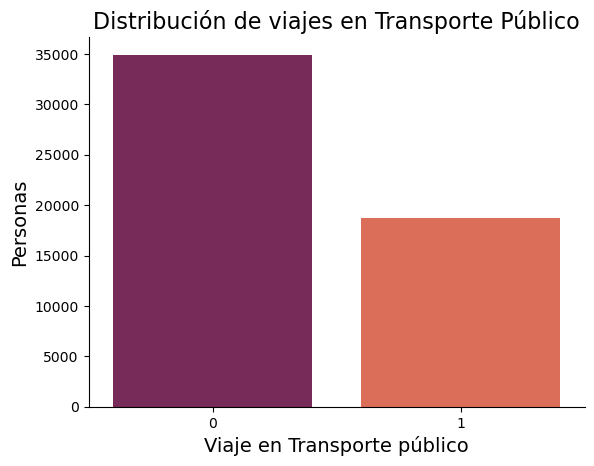

In [22]:
sns.countplot(x=mov_tp['modo_des'], palette="rocket")
plt.xlabel('Viaje en Transporte público', size=14)
plt.ylabel('Personas', size=14)
plt.title('Distribución de viajes en Transporte Público', fontsize=16)
sns.despine()

In [23]:
# Eliminamos aquellas variables que no queremos incluir en el Modelo y las guardamos en x.
x = mov_tp.drop(['id_persona', 'id_hogar', 'modo_des'], axis=1)

In [24]:
x.shape

(53614, 16)

In [25]:
lista_atributos = x.columns

In [26]:
lista_atributos

Index(['Unnamed: 0_x', 'veces_por_semana_viaja', 'tarifa_combinada',
       'partido_origen_viaje', 'partido_destino_viaje', 'duracion_minutos',
       'tipo_viaje', 'distancia_viaje_km', 'Unnamed: 0_y', 'edad', 'sexo',
       'ambito_cursando', 'nivel_aprobado', 'Trabaja_Si_No (0=SD)',
       'trabaja_como', 'licencia_de_conducir'],
      dtype='object')

In [27]:
# Seleccionamos las etiquetas y las guardamos en y.
y = mov_tp['modo_des']

In [28]:
x, y = np.array(x), np.array(y)

#### Separando Train / Test

Ahora tenemos que separar el dataset en conjuntos de Entrenamiento (X_train, y_train) y de Testeo (X_test, y_test) usando la función train_test_split de scikit-learn.

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    random_state=70)

In [31]:
X_train.shape

(42891, 16)

In [32]:
X_test.shape

(10723, 16)

### Modelos

In [33]:
from sklearn.neighbors import KNeighborsClassifier

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
from sklearn.model_selection import GridSearchCV

In [36]:
# Métricas
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

#### Clasificador KNN

Optimizamos los parámetros del clasificador kNN, empezando con encontrar el mejor K.

In [37]:
ACC_train = []
ACC_test = []

vecinos = [1, 3, 5, 10, 15, 20, 27, 50]
for n in vecinos:
    
    clf = KNeighborsClassifier(n_neighbors=n)
    
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    
    train_acc = accuracy_score(y_train, y_train_pred)
    ACC_train.append(train_acc)
    
    y_test_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    ACC_test.append(test_acc)

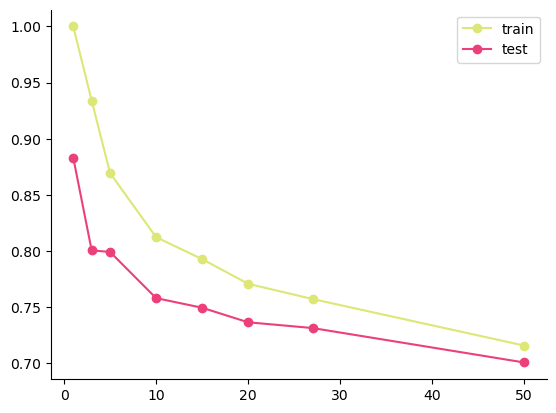

In [38]:
plt.plot(vecinos,ACC_train,'o-',label='train', color='#DCE775')
plt.plot(vecinos,ACC_test,'o-',label='test', color='#EC407A')
plt.legend()
sns.despine();

Y ahora hacemos una búsqueda con GridSearchCV para obtener los hiperparámetros óptimos utilizando ademas validación cruzada.

In [39]:
# Valores para los parámetros a optimizar
param_grid_vec = {
    'n_neighbors': [3, 5, 10,15,16, 25, 26],
    'weights': ['uniform','distance'],
    'metric': ['euclidean', 'manhattan'],
}

In [40]:
knn_search = KNeighborsClassifier()

In [41]:
vecinos_search = GridSearchCV(estimator=knn_search, param_grid=param_grid_vec,
                         cv=3, verbose=2, n_jobs=-1)

In [42]:
vecinos_search.fit(X_train, y_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 10, 15, 16, 25, 26],
                         'weights': ['uniform', 'distance']},
             verbose=2)

In [43]:
# Mejores hiperparametros
vecinos_search.best_params_

{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}

Entrenamos entonces el Modelo Final.

In [44]:
knn_best = KNeighborsClassifier(metric='manhattan', n_neighbors=10, weights='distance')

In [45]:
knn_best.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=10, weights='distance')

In [46]:
new_predictions = knn_best.predict(X_test)

**Metricas**

Matriz de confusión:

True Negative (TN)  |  False positive (FP)   
= = = = = = = = = = = = = = = = = = = = =       
False negative (FN) | True positive (TP)  


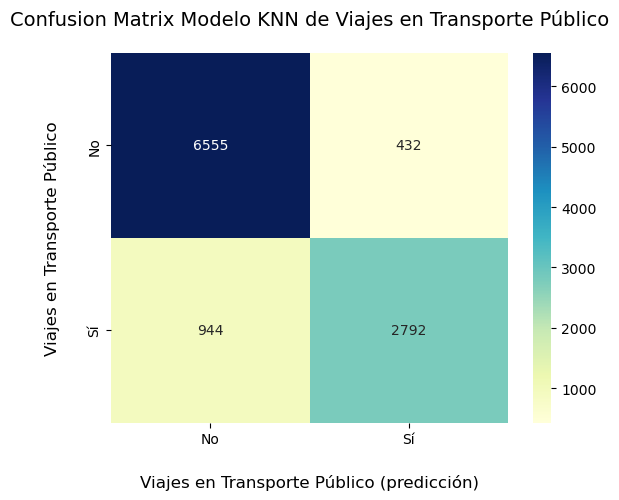

In [47]:
plt.figure()
random_confusion = confusion_matrix(y_test, new_predictions)
ax=sns.heatmap(random_confusion, cmap="YlGnBu",annot=True,fmt='d');
ax.set_xlabel("Viajes en Transporte Público (predicción)", fontsize=12, labelpad=20)
ax.xaxis.set_ticklabels(['No', 'Sí'])
ax.set_ylabel("Viajes en Transporte Público", fontsize=12, labelpad=20)
ax.yaxis.set_ticklabels(['No', 'Sí'])
ax.set_title("Confusion Matrix Modelo KNN de Viajes en Transporte Público", fontsize=14, pad=20)
plt.show()

La Matriz de Confusión nos permite evaluar la performance de nuestro Modelo de Clasificación, dándonos una combinación de los valores actuales y estimados.

De esta manera, observamos que 6.141 valores se predijeron Negativos y eran efectivamente Negativos y 2.801 eran efectivamente Positivos y se predijeron como Positivos.

Dentro de los Falsos Positivos y Falsos Negativos, tenemos para computar 842, en los que se predijo que sí tomaban el transporte público cuando no ocurre conforme a la encuesta y 935 como que no viajaban en transporte público, cuando sí lo hacen.

In [48]:
print(f"Accuracy: {accuracy_score(y_test, new_predictions)*100 :.2f}%")
print(f"Precision: {precision_score(y_test, new_predictions)*100 :.2f}%")
print(f"Recall: {recall_score(y_test, new_predictions)*100 :.2f}%")
print(f"F1 score: {f1_score(y_test, new_predictions)*100 :.2f}%")

Accuracy: 87.17%
Precision: 86.60%
Recall: 74.73%
F1 score: 80.23%


#### Clasificador Random Forest

In [49]:
# Valores para los parámetros a optimizar
param_grid_vec_random = {
    'max_features': ['auto', 'sqrt', 'log2', None],
    'max_depth': [2, 3, 4, 8, 10],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False],
    'n_estimators': [10, 15, 20, 30, 50, 100]

}

In [50]:
random_forest = RandomForestClassifier()

In [51]:
rf_search = GridSearchCV(estimator=random_forest, param_grid=param_grid_vec_random,
                         cv=3, verbose=2, n_jobs=-1)

In [52]:
rf_search.fit(X_train, y_train)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 8, 10],
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'n_estimators': [10, 15, 20, 30, 50, 100]},
             verbose=2)

In [53]:
# Mejores hiperparámetros
rf_search.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': None,
 'n_estimators': 50}

In [54]:
rf_best = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=10, max_features=None, n_estimators=50)

In [55]:
rf_best.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features=None, n_estimators=50)

In [56]:
new_predictions_rf = rf_best.predict(X_test)

**Métricas**

Matriz de Confusión:

True Negative (TN)  |  False positive (FP)   
= = = = = = = = = = = = = = = = = = = = =       
False negative (FN) | True positive (TP)  


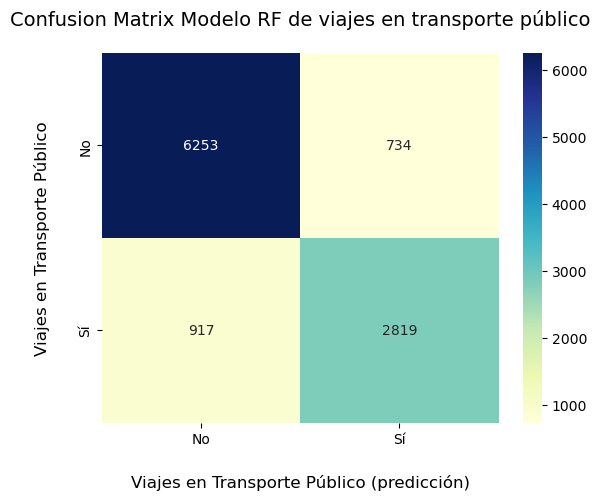

In [57]:
plt.figure()
random_confusion = confusion_matrix(y_test, new_predictions_rf)
ax=sns.heatmap(random_confusion, cmap="YlGnBu",annot=True,fmt='d');
ax.set_xlabel("Viajes en Transporte Público (predicción)", fontsize=12, labelpad=20)
ax.xaxis.set_ticklabels(['No', 'Sí'])
ax.set_ylabel("Viajes en Transporte Público", fontsize=12, labelpad=20)
ax.yaxis.set_ticklabels(['No', 'Sí'])
ax.set_title("Confusion Matrix Modelo RF de viajes en transporte público", fontsize=14, pad=20)
plt.show()

In [58]:
print(f"Accuracy: {accuracy_score(y_test, new_predictions_rf)*100 :.2f}%")
print(f"Precision: {precision_score(y_test, new_predictions_rf)*100 :.2f}%")
print(f"Recall: {recall_score(y_test, new_predictions_rf)*100 :.2f}%")
print(f"F1 score: {f1_score(y_test, new_predictions_rf)*100 :.2f}%")

Accuracy: 84.60%
Precision: 79.34%
Recall: 75.46%
F1 score: 77.35%


Variable: duracion_minutos Importance: 0.53
Variable: distancia_viaje_km Importance: 0.2
Variable: licencia_de_conducir Importance: 0.09
Variable: edad Importance: 0.04
Variable: Unnamed: 0_x Importance: 0.03
Variable: Unnamed: 0_y Importance: 0.03
Variable: partido_origen_viaje Importance: 0.02
Variable: partido_destino_viaje Importance: 0.02
Variable: veces_por_semana_viaja Importance: 0.01
Variable: tarifa_combinada Importance: 0.01
Variable: tipo_viaje Importance: 0.01
Variable: ambito_cursando Importance: 0.01
Variable: nivel_aprobado Importance: 0.01
Variable: trabaja_como Importance: 0.01
Variable: sexo Importance: 0.0
Variable: Trabaja_Si_No (0=SD) Importance: 0.0


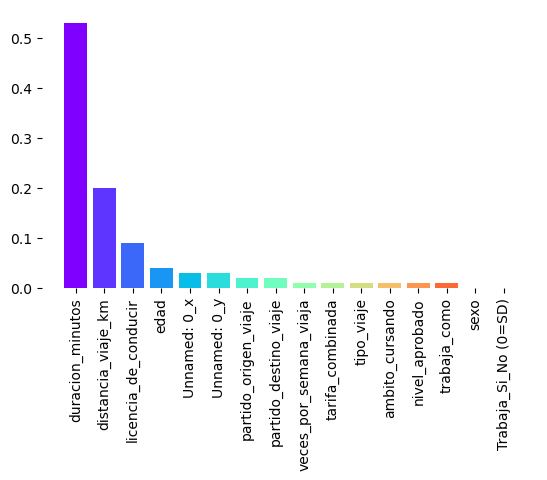

In [59]:
feature_importance(rf_best, lista_atributos)

Del análisis se desprende que el Modelo de Random Forest predice mejor que el K Vecinos. Las variables que más explican la decisión de viajar en transporte público son la duración del viaje, su distancia, si la persona cuenta con Licencia de Conducir y su edad.